In [3]:
import xarray as xr
from scipy.interpolate import griddata
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Prepare training set

In [45]:
file_path = "/Users/wangy/Documents/MACS/Thesis"
training_set_2015 = pd.read_csv(f"{file_path}/train_set/train_set_3_cities_2015.csv", index_col=0)
training_set_2016 = pd.read_csv(f"{file_path}/train_set/train_set_3_cities_2016.csv", index_col=0)

In [47]:
train_set_all = pd.concat([training_set_2015, training_set_2016], ignore_index=True)
# train_set_all = training_set_2016 
print(train_set_all)

                        time          y         x        tas      Coast.nc  \
0                 2015-07-01  51.332417  4.513800  20.664545  17846.568359   
1                 2015-07-01  51.336610  4.264203  19.721277   1818.640032   
2                 2015-07-01  51.212650  4.515183  22.342126  23820.942030   
3                 2015-07-01  51.311340  4.227067  20.765131   4500.000000   
4                 2015-07-01  51.312443  4.285940  21.813562   4743.416504   
...                      ...        ...       ...        ...           ...   
4655995  2016-07-10 23:00:00  51.124294  3.660715  18.751581  24698.177734   
4655996  2016-07-10 23:00:00  51.065052  3.551365  18.089471  33615.472656   
4655997  2016-07-10 23:00:00  51.119267  3.767546  19.199121  23537.205078   
4655998  2016-07-10 23:00:00  51.140090  3.685806  18.473291  22610.837891   
4655999  2016-07-10 23:00:00  51.134712  3.837187  18.659509  21503.317721   

         LCZcorine_UrbClim_2015_01_v1.0.nc  height.nc  \
0     

In [48]:
# delete all the NaN value here
train_set_all.dropna(inplace=True)
train_set_all.reset_index(drop=True, inplace=True)

y_train = pd.DataFrame()
# Calculate the residue
y_train['residue'] = train_set_all['tas'] - train_set_all['t2m_corrected']
X_train = train_set_all.drop(columns=['x','y','time','tas','hour'])

### Prepare testing set

In [49]:
def add_time_feature(all_variables):
    all_variables['time'] = pd.to_datetime(all_variables['time'], format='mixed')
    # Extract the hour of the day
    all_variables['hour'] = all_variables['time'].dt.hour
    # Convert time features using sin and cos
    all_variables['hour_sin'] = np.sin(2 * np.pi * all_variables['hour'] / 24)
    all_variables['hour_cos'] = np.cos(2 * np.pi * all_variables['hour'] / 24)

In [50]:
def standardize_columns(columns):
    return [col.replace('_Brussels', '').replace('_Antwerp', '').replace('_Ghent', '').replace('_Charleroi', '') for col in columns]

In [51]:
urbclim_and_feature = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/Urbclim_and_feature/Brussels_urbclim_and_features_2017_07_01to03.csv')
era5 = pd.read_csv('/Users/wangy/Documents/MACS/Thesis/ERA5_variables/Brussels/ERA5_2017_07_01to03_Brussels_Corrected_v1.csv')

urbclim_and_feature = urbclim_and_feature.drop(columns=[ 'Unnamed: 0'])
era5_new = era5.drop(columns=['x','y','time','Unnamed: 0','t2m'])
test_set = pd.concat([urbclim_and_feature,era5_new], axis=1)
add_time_feature(test_set)

# Adjust the column order of test set
test_set.columns = standardize_columns(test_set.columns)
base_columns = train_set_all.columns
test_set = test_set[base_columns]

In [52]:
# test_set = test_set.drop(columns = {"AHF.nc","elevation_UrbClim_2015_01_v1.0.nc"})

# delete all the NaN value here
test_set.dropna(inplace=True)
test_set.reset_index(drop=True, inplace=True)

In [53]:
y_test = pd.DataFrame()
# Calculate the residue
y_test['residue'] = test_set['tas'] - test_set['t2m_corrected']
X_test = test_set.drop(columns=['x','y','time','tas','hour'])

print(X_test.columns)

Index(['Coast.nc', 'LCZcorine_UrbClim_2015_01_v1.0.nc', 'height.nc',
       'imperv_UrbClim_2015_01_v1.0.nc', 'LCZ_UrbClim_2015_01_v1.0.nc',
       'population.nc', 'surface.nc', 'volume.nc', 'hour_sin', 'hour_cos',
       'u10', 'v10', 'blh', 'cape', 'kx', 'ssr', 'str', 'sp', 'sshf', 'tcc',
       'tcw', 'tp', 't2m_corrected'],
      dtype='object')


In [54]:
print(y_train)
print(X_train)
print(y_test)
print(X_test)

          residue
0        0.496688
1       -0.496287
2        2.038780
3        0.579338
4        1.614004
...           ...
4649275  0.648722
4649276  0.153920
4649277  0.909329
4649278  0.331478
4649279  0.231375

[4649280 rows x 1 columns]
             Coast.nc  LCZcorine_UrbClim_2015_01_v1.0.nc  height.nc  \
0        17846.568359                               21.0   0.013173   
1         1818.640032                               43.0   0.000000   
2        23820.942030                                3.0   3.595983   
3         4500.000000                               12.0   0.000000   
4         4743.416504                               37.0   0.009319   
...               ...                                ...        ...   
4649275  24698.177734                               20.0   0.273453   
4649276  33615.472656                               20.0   0.000000   
4649277  23537.205078                                5.0   4.883322   
4649278  22610.837891                         

### Check data quality

                  y             x           tas      Coast.nc  \
count  4.649280e+06  4.649280e+06  4.649280e+06  4.649280e+06   
mean   5.101925e+01  4.188511e+00  1.942078e+01  3.947044e+04   
std    3.241927e-01  3.444139e-01  5.057010e+00  3.418555e+04   
min    5.032253e+01  3.532958e+00  6.234674e+00  0.000000e+00   
25%    5.099680e+01  3.814758e+00  1.578237e+01  1.850000e+04   
50%    5.113689e+01  4.329845e+00  1.850826e+01  2.582570e+04   
75%    5.123775e+01  4.466199e+00  2.249921e+01  3.785499e+04   
max    5.138953e+01  4.630889e+00  3.570394e+01  1.154264e+05   

       LCZcorine_UrbClim_2015_01_v1.0.nc     height.nc  \
count                       4.649280e+06  4.649280e+06   
mean                        1.309488e+01  8.298270e-01   
std                         1.052706e+01  1.573080e+00   
min                         1.000000e+00  0.000000e+00   
25%                         2.000000e+00  0.000000e+00   
50%                         1.200000e+01  1.027838e-01   
75%     

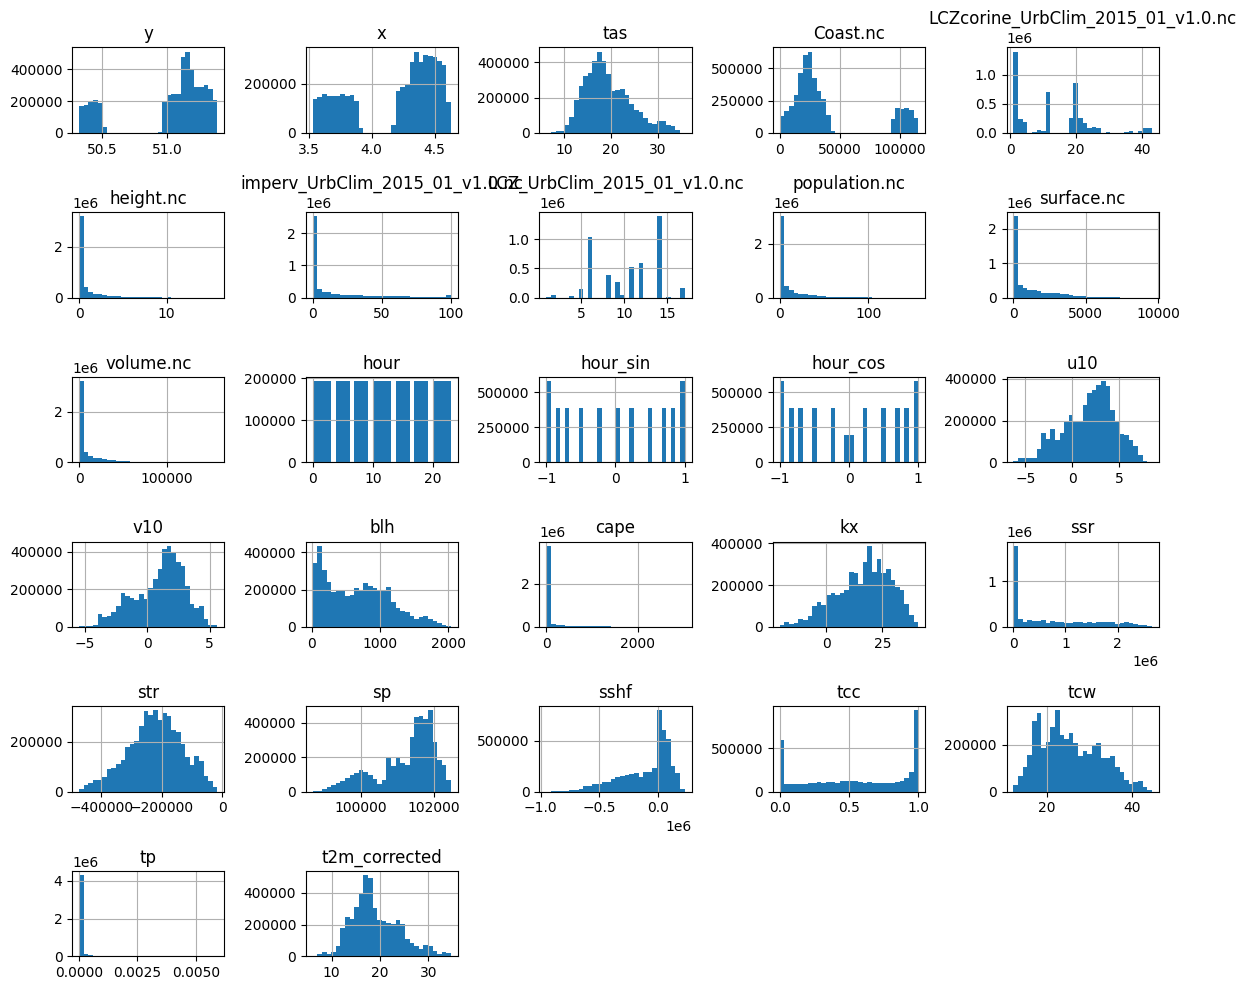

In [17]:
# 假设你的数据集是 train_set_all
# 查看每个特征的基本统计信息
print(train_set_all.describe())

# 可视化每个特征的分布
train_set_all.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()


                      time             y             x           tas  \
count              6519384  6.519384e+06  6.519384e+06  6.519384e+06   
mean   2017-07-02 11:30:00  5.084335e+01  4.372353e+00  1.645012e+01   
min    2017-07-01 00:00:00  5.070001e+01  4.143460e+00  8.665125e+00   
25%    2017-07-01 17:45:00  5.077597e+01  4.265861e+00  1.473641e+01   
50%    2017-07-02 11:30:00  5.084336e+01  4.372366e+00  1.592233e+01   
75%    2017-07-03 05:15:00  5.091073e+01  4.478880e+00  1.786710e+01   
max    2017-07-03 23:00:00  5.098723e+01  4.599575e+00  2.425097e+01   
std                    NaN  7.802335e-02  1.233621e-01  2.791726e+00   

           Coast.nc  LCZcorine_UrbClim_2015_01_v1.0.nc     height.nc  \
count  6.519384e+06                       6.519384e+06  6.519384e+06   
mean   5.696296e+04                       1.001934e+01  1.002972e+00   
min    4.031199e+04                       1.000000e+00  0.000000e+00   
25%    4.954039e+04                       2.000000e+00  3.88632

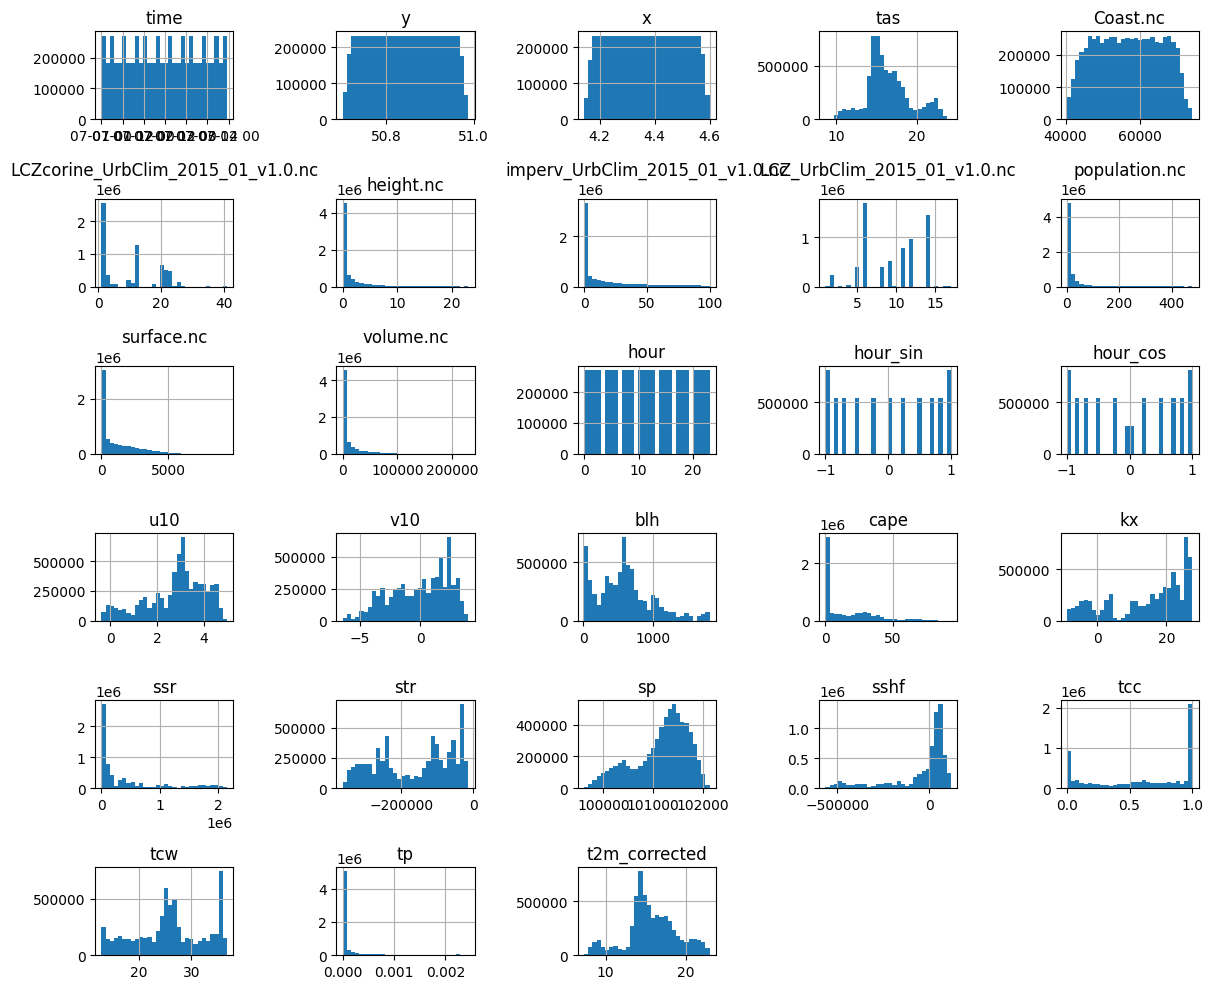

In [18]:
print(test_set.describe())

# 可视化每个特征的分布
test_set.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

In [66]:
def plot_tem_over_time(df,city):
    plt.figure(figsize=(12, 6))
    plt.plot(df['time'], df['tas'], label='TAS (Temperature)', color='blue', linestyle='-', linewidth=1)
    plt.plot(df['time'], df['t2m_corrected'], label='T2M Corrected', color='orange', linestyle='--', linewidth=1)
    plt.legend()
    plt.title(f'Temperature Trends Over Time {city}', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

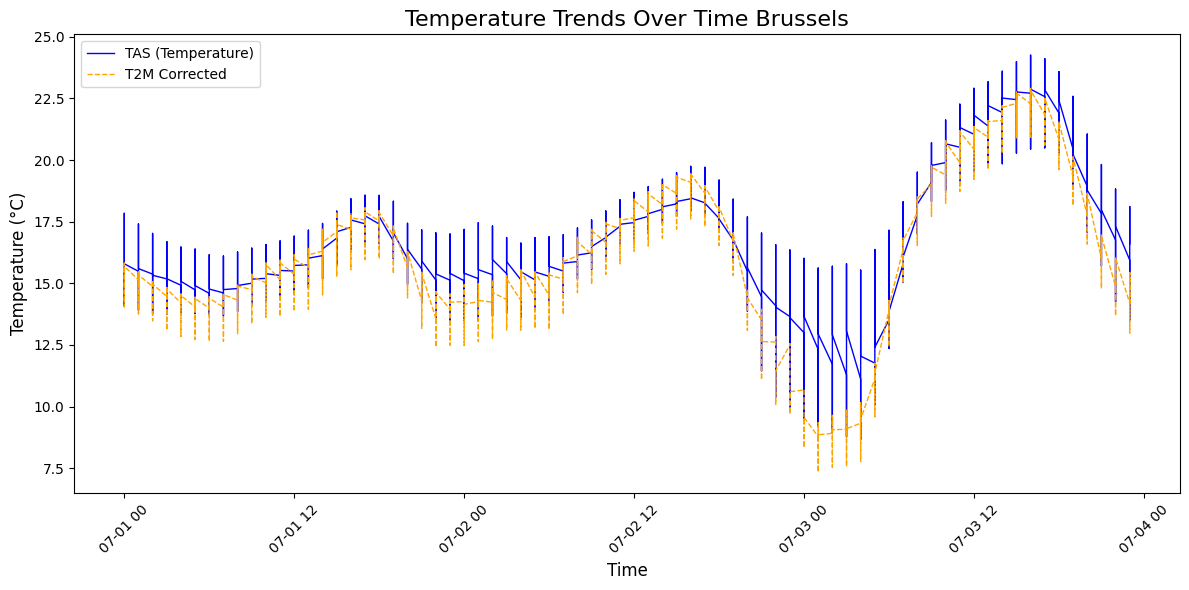

In [12]:
plot_tem_over_time(test_set,'Brussels')

### Util code

In [13]:
def plot_y(df, model_name, feature_name):
  plt.figure(figsize=(10, 8))
  plt.scatter(df['x'], df['y'], c=df[feature_name], cmap='viridis', s=1, vmin = 13, vmax = 19)  # 使用 'viridis' 色彩映射
  # plt.scatter(df['x'], df['y'], c=df[feature_name], cmap='viridis', s=1)
  plt.colorbar(label= feature_name)
  plt.xlabel('Longitude (x)')
  plt.ylabel('Latitude (y)')
  plt.title(f'Geographical Distribution of Temperature - {model_name}')
  plt.show()

In [14]:
# compute the errors
# compute MAE (Mean Absolute Error)
def calculate_errors(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae}")
    
    # compute MSE (Mean Squared Error)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse}")
    
    # compute RMSE (Root Mean Squared Error)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    return mae, mse, rmse

### Baseline computation

In [26]:
maes_general = {}
maes_day = {}
maes_night = {}

mses_general = {}
mses_day = {}
mses_night = {}

rmses_general = {}
rmses_day = {}
rmses_night = {}
errors = {"general_error": [maes_general, mses_general, rmses_general], "day_error":[ maes_day, mses_day, rmses_day], "night_error":[maes_night, mses_night, rmses_night]}

             tas         x          y
0      15.632135  4.207803  50.700043
1      15.149103  4.209215  50.700110
2      14.975702  4.210626  50.700184
3      15.035272  4.212038  50.700256
4      14.915277  4.213450  50.700325
...          ...       ...        ...
90542  15.303064  4.547782  50.986958
90543  15.286371  4.549203  50.987026
90544  15.476862  4.550624  50.987090
90545  15.270410  4.552045  50.987160
90546  15.791254  4.553465  50.987225

[90547 rows x 3 columns]
tas min:  14.061822509765648
tas max:  17.839501953125023


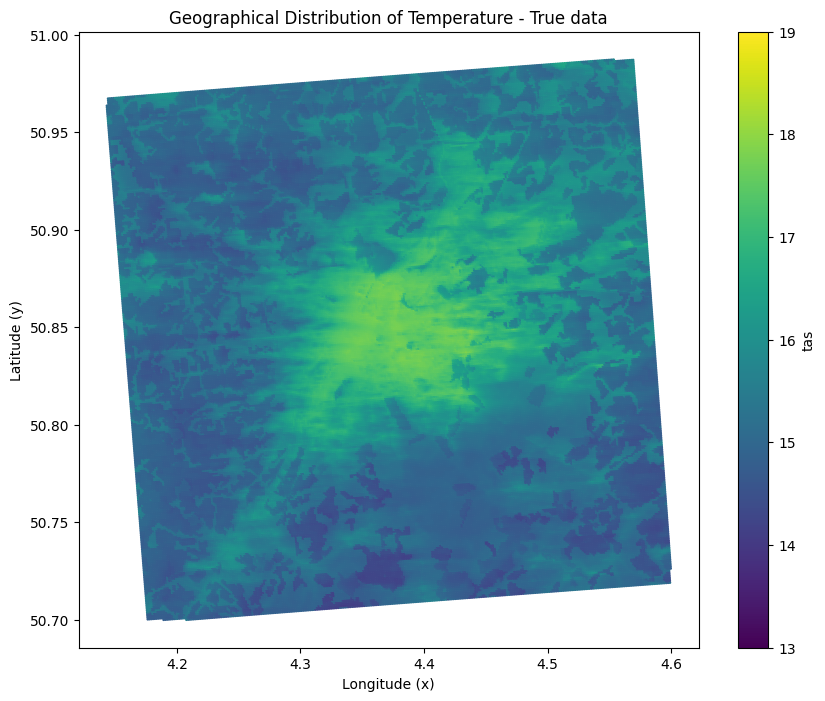

In [16]:
# first_timestamp_true = urbclim_true_value[(urbclim_true_value['time']=="2016-07-01 00:00:00") | (urbclim_true_value['time']=="2016-07-01")]
first_timestamp_true = test_set[(test_set['time']=="2017-07-01 00:00:00")][['tas','x','y']]
print(first_timestamp_true)
tas_min = first_timestamp_true['tas'].min()
tas_max = first_timestamp_true['tas'].max()
print("tas min: " ,tas_min)
print("tas max: " ,tas_max)
plot_y(first_timestamp_true, 'True data', 'tas')

In [80]:
# calculate the error matric for corrected era5 with urbclim for test set
urbclim_true = train_set['tas']
era5_true = train_set['t2m_corrected']
train_set['time'] = pd.to_datetime(train_set['time'], format='mixed')
urbclim_true_day = train_set[(train_set['time'].dt.hour >= 6) & (train_set['time'].dt.hour < 18)][['tas']]
urbclim_true_night =  train_set[(train_set['time'].dt.hour < 6) | (train_set['time'].dt.hour >= 18)][['tas']]
era5_true_day = train_set[(train_set['time'].dt.hour >= 6) & (train_set['time'].dt.hour < 18)][['t2m_corrected']]
era5_true_night = train_set[(train_set['time'].dt.hour < 6) | (train_set['time'].dt.hour >= 18)][['t2m_corrected']]

In [81]:
model_name = "baseline"
maes_general[model_name], mses_general[model_name], rmses_general[model_name] = calculate_errors(urbclim_true, era5_true)
print("Errors during day:")
maes_day[model_name], mses_day[model_name], rmses_day[model_name] = calculate_errors(urbclim_true_day['tas'], era5_true_day['t2m_corrected'])
print("Errors during night:")
maes_night[model_name], mses_night[model_name],  rmses_night[model_name] = calculate_errors(urbclim_true_night['tas'], era5_true_night['t2m_corrected'])

Mean Absolute Error (MAE): 0.986271010910397
Mean Squared Error (MSE): 1.8665694782248323
Root Mean Squared Error (RMSE): 1.3662245343371755
Errors during day:
Mean Absolute Error (MAE): 0.8218020698595184
Mean Squared Error (MSE): 1.3880531002445218
Root Mean Squared Error (RMSE): 1.1781566535247008
Errors during night:
Mean Absolute Error (MAE): 1.1507399519612742
Mean Squared Error (MSE): 2.345085856205139
Root Mean Squared Error (RMSE): 1.5313673158994674


### Scale data

In [56]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the normalizer
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the training set
X_train_normalized = scaler.fit_transform(X_train)

# Normalize the test set using the parameters of the training set
X_test_normalized = scaler.transform(X_test)

In [57]:
train_set = train_set_all
train_set['time'] = pd.to_datetime(train_set['time'], format='mixed')
y_test[['y','x','time']] = test_set[['y','x','time']]
y_test_day = y_test[(y_test['time'].dt.hour >= 6) & (y_test['time'].dt.hour < 18)]
y_test_night = y_test[(y_test['time'].dt.hour < 6) | (y_test['time'].dt.hour >= 18)]

y_train[['y','x','time']] = train_set[['y','x','time']]
y_train_day = y_train[(y_train['time'].dt.hour >= 6) & (y_train['time'].dt.hour < 18)]
y_train_night = y_train[(y_train['time'].dt.hour < 6) | (y_train['time'].dt.hour >= 18)]

### Linear regression model

In [62]:
linear_model = LinearRegression()
linear_model.fit(X_train_normalized, y_train['residue'])


# Predict y
y_pred_lr = linear_model.predict(X_train_normalized)
y_pred_lr = pd.DataFrame(y_pred_lr, columns=['residue'])
print(y_pred_lr)

          residue
0       -0.248393
1       -0.787394
2        0.870772
3       -0.139183
4       -0.530776
...           ...
4649275  0.626410
4649276 -0.000420
4649277  1.162478
4649278  0.107238
4649279  0.135572

[4649280 rows x 1 columns]


In [63]:
# View model coefficients and intercept
print("Coefficients (weights):", linear_model.coef_)   
print("Intercept (bias):", linear_model.intercept_)   

# Assume your feature name is feature_names
feature_names = X_train.columns
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Weight': linear_model.coef_.ravel()
})

print(coefficients)

Coefficients (weights): [-1.42994191 -0.66392736 -0.99643391  0.56765142 -1.02282065 -0.0862491
 -0.37680725  1.72749943 -1.24765448 -0.31302411 -0.21070206 -0.10479258
 -1.80193836  0.6811453  -0.2939714  -0.25556385 -0.55805245 -2.49387665
 -2.17920421 -0.15561916  1.8124328  -1.81406098 -3.20417354]
Intercept (bias): 7.651834587299486
                              Feature    Weight
0                            Coast.nc -1.429942
1   LCZcorine_UrbClim_2015_01_v1.0.nc -0.663927
2                           height.nc -0.996434
3      imperv_UrbClim_2015_01_v1.0.nc  0.567651
4         LCZ_UrbClim_2015_01_v1.0.nc -1.022821
5                       population.nc -0.086249
6                          surface.nc -0.376807
7                           volume.nc  1.727499
8                            hour_sin -1.247654
9                            hour_cos -0.313024
10                                u10 -0.210702
11                                v10 -0.104793
12                                bl

In [64]:
y_pred_lr[['y','x','time']] = train_set[['y','x','time']]
y_pred_lr_day = y_pred_lr[(y_pred_lr['time'].dt.hour >= 6) & (y_pred_lr['time'].dt.hour < 18)]
y_pred_lr_night = y_pred_lr[(y_pred_lr['time'].dt.hour < 6) | (y_pred_lr['time'].dt.hour >= 18)]

print(y_pred_lr_day)
print(y_pred_lr_night)
print(y_test_day)
print(y_test_night)

          residue          y         x                time
27126   -0.467964  51.332417  4.513800 2015-07-01 06:00:00
27127   -1.038977  51.336610  4.264203 2015-07-01 06:00:00
27128    0.655139  51.212650  4.515183 2015-07-01 06:00:00
27129   -0.388448  51.311340  4.227067 2015-07-01 06:00:00
27130   -0.775749  51.312443  4.285940 2015-07-01 06:00:00
...           ...        ...       ...                 ...
4630393  1.069385  51.124294  3.660715 2016-07-10 17:00:00
4630394  0.343436  51.065052  3.551365 2016-07-10 17:00:00
4630395  1.550561  51.119267  3.767546 2016-07-10 17:00:00
4630396  0.578257  51.140090  3.685806 2016-07-10 17:00:00
4630397  0.529101  51.134712  3.837187 2016-07-10 17:00:00

[2324640 rows x 4 columns]
          residue          y         x                time
0       -0.248393  51.332417  4.513800 2015-07-01 00:00:00
1       -0.787394  51.336610  4.264203 2015-07-01 00:00:00
2        0.870772  51.212650  4.515183 2015-07-01 00:00:00
3       -0.139183  51.311340

In [65]:
print("Errors:")
model_name = "LR"
maes_general[model_name], mses_general[model_name], rmses_general[model_name] = calculate_errors(y_train['residue'], y_pred_lr['residue'])
print("Errors during day:")
maes_day[model_name], mses_day[model_name], rmses_day[model_name] = calculate_errors(y_train_day['residue'], y_pred_lr_day['residue'])
print("Errors during night:")
maes_night[model_name], mses_night[model_name],  rmses_night[model_name] = calculate_errors(y_train_night['residue'], y_pred_lr_night['residue'])

Errors:
Mean Absolute Error (MAE): 0.857660409276656
Mean Squared Error (MSE): 1.3109393698353975
Root Mean Squared Error (RMSE): 1.1449626063044145
Errors during day:
Mean Absolute Error (MAE): 0.7670075528622741
Mean Squared Error (MSE): 1.055177066675401
Root Mean Squared Error (RMSE): 1.0272181203013315
Errors during night:
Mean Absolute Error (MAE): 0.948313265691037
Mean Squared Error (MSE): 1.5667016729953958
Root Mean Squared Error (RMSE): 1.2516795408551646


In [67]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_lr = pd.DataFrame()

urbclim_pred_lr['tas'] = y_pred_lr['residue'] + train_set['t2m_corrected']
urbclim_pred_lr[['y','x','time']] = train_set[['y','x','time']]

print(urbclim_pred_lr)

               tas          y         x                time
0        19.919464  51.332417  4.513800 2015-07-01 00:00:00
1        19.430169  51.336610  4.264203 2015-07-01 00:00:00
2        21.174118  51.212650  4.515183 2015-07-01 00:00:00
3        20.046610  51.311340  4.227067 2015-07-01 00:00:00
4        19.668782  51.312443  4.285940 2015-07-01 00:00:00
...            ...        ...       ...                 ...
4649275  18.729269  51.124294  3.660715 2016-07-10 23:00:00
4649276  17.935132  51.065052  3.551365 2016-07-10 23:00:00
4649277  19.452270  51.119267  3.767546 2016-07-10 23:00:00
4649278  18.249051  51.140090  3.685806 2016-07-10 23:00:00
4649279  18.563706  51.134712  3.837187 2016-07-10 23:00:00

[4649280 rows x 4 columns]


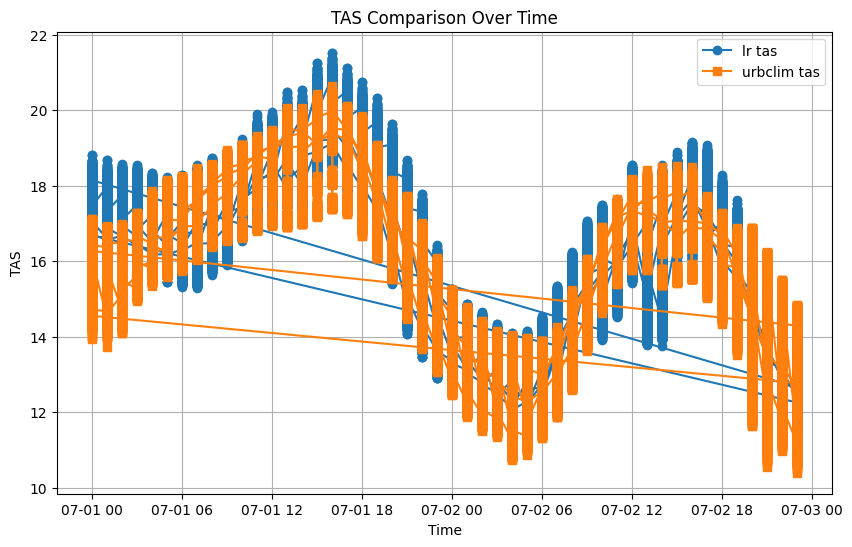

In [79]:
# Merge two DataFrames, aligning by time
merged_df = pd.DataFrame()
merged_df[['tas_lr']] = urbclim_pred_lr[['tas']]
merged_df[['tas_true','y','x','time']] = train_set[['tas', 'y','x','time']]
# merged_df = merged_df[merged_df['time'] == '2015-07-01']
merged_df = merged_df[(merged_df['time'] >= '2016-07-01') & (merged_df['time'] < '2016-07-03')]

# Draw a line chart
plt.figure(figsize=(10, 6))
plt.plot(merged_df['time'], merged_df['tas_lr'], label='lr tas', marker='o')
plt.plot(merged_df['time'], merged_df['tas_true'], label='urbclim tas', marker='s')

# Add title and labels
plt.title('TAS Comparison Over Time')
plt.xlabel('Time')
plt.ylabel('TAS')
plt.legend()
plt.grid(True)

plt.show()

             tas          y         x       time
0      16.508490  50.700043  4.207803 2017-07-01
1      16.422416  50.700110  4.209215 2017-07-01
2      16.251131  50.700184  4.210626 2017-07-01
3      16.216643  50.700256  4.212038 2017-07-01
4      16.181892  50.700325  4.213450 2017-07-01
...          ...        ...       ...        ...
90542  16.895577  50.986958  4.547782 2017-07-01
90543  16.740950  50.987026  4.549203 2017-07-01
90544  17.077120  50.987090  4.550624 2017-07-01
90545  16.997006  50.987160  4.552045 2017-07-01
90546  16.755191  50.987225  4.553465 2017-07-01

[90547 rows x 4 columns]
tas min:  15.225851379155564
tas max:  18.164148206479254


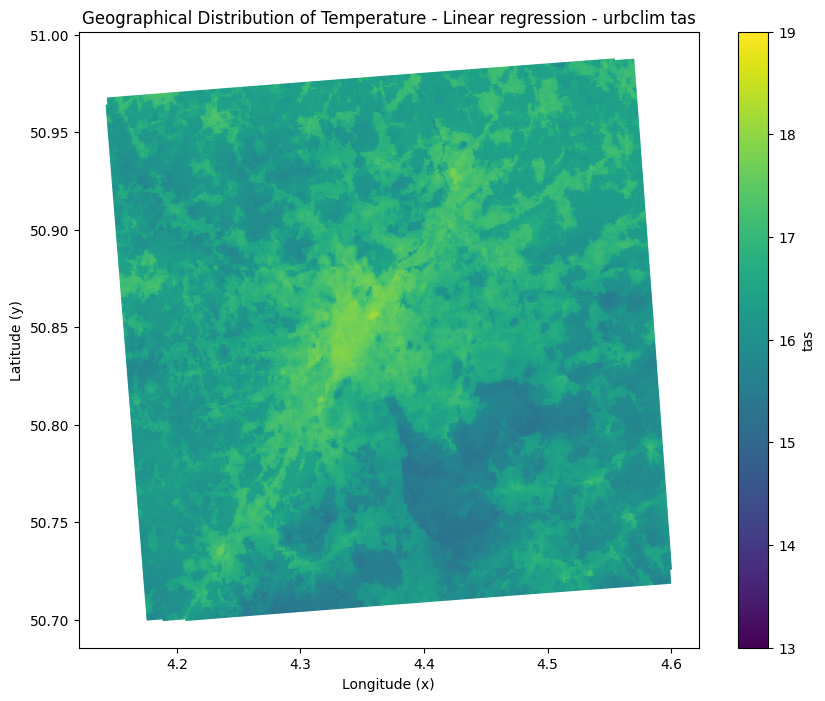

In [25]:
# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2015-07-01 00:00:00") | (urbclim_pred['time']=="2015-07-01")]
first_stamp_data_lr = urbclim_pred_lr[(urbclim_pred_lr['time']=="2017-07-01 00:00:00")]
print(first_stamp_data_lr)
tas_min_lr = first_stamp_data_lr['tas'].min()
tas_max_lr = first_stamp_data_lr['tas'].max()
print("tas min: " ,tas_min_lr)
print("tas max: " ,tas_max_lr)
plot_y(first_stamp_data_lr, 'Linear regression - urbclim tas', 'tas')

### NN model

In [62]:
# Hyperparameter definition
input_size = X_train.shape[1]  
hidden_sizes = [100, 50, 10]  # hidden layer size
output_size = 1  
learning_rate = 0.001
epochs = 10
# early_stopping_patience = 2

In [63]:
# Define the NN model
class NNmodel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NNmodel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.ReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.ReLU(),
            # nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            # nn.ReLU(),
            nn.Linear(hidden_sizes[1], output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [64]:
# Create a model instance
model = NNmodel(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()  # Loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [65]:
# Data preparation
train_dataset = TensorDataset(torch.tensor(X_train_normalized, dtype=torch.float32), 
                               torch.tensor(y_train['residue'], dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_test_normalized, dtype=torch.float32), 
                             torch.tensor(y_test['residue'], dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model training
best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Model validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # patience_counter = 0
        best_model_state = model.state_dict()  # Save the Optimal result
    # else:
    #     patience_counter += 1
    #     if patience_counter >= early_stopping_patience:
    #         print("Early stopping triggered!")
    #         break




Epoch 1/10, Train Loss: 0.2521, Val Loss: 1.0842
Epoch 2/10, Train Loss: 0.1935, Val Loss: 1.3722
Epoch 3/10, Train Loss: 0.1762, Val Loss: 1.5588
Epoch 4/10, Train Loss: 0.1659, Val Loss: 1.7047
Epoch 5/10, Train Loss: 0.1591, Val Loss: 2.0998
Epoch 6/10, Train Loss: 0.1544, Val Loss: 2.2407
Epoch 7/10, Train Loss: 0.1511, Val Loss: 2.5284
Epoch 8/10, Train Loss: 0.1488, Val Loss: 2.4825
Epoch 9/10, Train Loss: 0.1467, Val Loss: 2.6100
Epoch 10/10, Train Loss: 0.1449, Val Loss: 2.8007


In [48]:
def plot_losses(train_loss, val_loss):

    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, '--', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

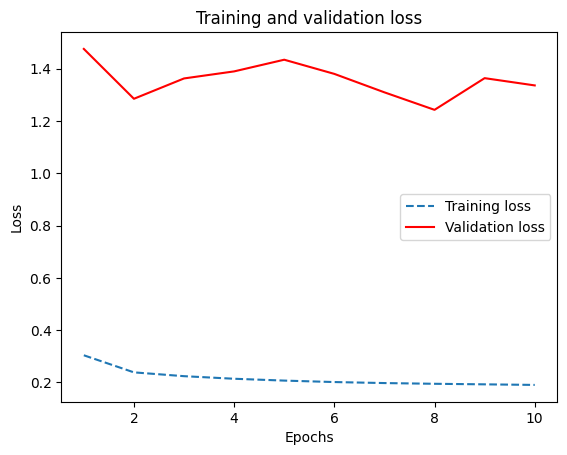

In [49]:
plot_losses(train_loss=train_losses, val_loss=val_losses)

In [50]:
# Load the optimal model
model.load_state_dict(best_model_state)

# Test set prediction
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_pred = model(X_test_tensor).detach().numpy()

# Transform into DataFrame
y_pred_nn = pd.DataFrame(y_pred, columns=['residue'])
print(y_pred_nn)

          residue
0        1.971065
1        1.692713
2        1.685739
3        1.763723
4        1.661224
...           ...
6519379  0.101279
6519380 -0.799639
6519381  0.236889
6519382  0.154400
6519383 -0.705089

[6519384 rows x 1 columns]


In [51]:
y_pred_nn[['y','x','time']] = test_set[['y','x','time']]

y_pred_nn_day = y_pred_nn[(y_pred_nn['time'].dt.hour >= 6) & (y_pred_nn['time'].dt.hour < 18)]
y_pred_nn_night = y_pred_nn[(y_pred_nn['time'].dt.hour < 6) | (y_pred_nn['time'].dt.hour >= 18)]

print(y_pred_nn_day)
print(y_pred_nn_night)

          residue          y         x                time
543282  -0.146951  50.700043  4.207803 2017-07-01 06:00:00
543283  -0.206955  50.700110  4.209215 2017-07-01 06:00:00
543284  -0.230216  50.700184  4.210626 2017-07-01 06:00:00
543285  -0.221749  50.700256  4.212038 2017-07-01 06:00:00
543286  -0.225647  50.700325  4.213450 2017-07-01 06:00:00
...           ...        ...       ...                 ...
5976097  0.560668  50.986958  4.547782 2017-07-03 17:00:00
5976098  0.306571  50.987026  4.549203 2017-07-03 17:00:00
5976099  0.269643  50.987090  4.550624 2017-07-03 17:00:00
5976100  0.238736  50.987160  4.552045 2017-07-03 17:00:00
5976101  0.271124  50.987225  4.553465 2017-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        1.971065  50.700043  4.207803 2017-07-01 00:00:00
1        1.692713  50.700110  4.209215 2017-07-01 00:00:00
2        1.685739  50.700184  4.210626 2017-07-01 00:00:00
3        1.763723  50.700256

In [52]:
model_name = "NN"
maes_general[model_name], mses_general[model_name], rmses_general[model_name] = calculate_errors(y_test['residue'], y_pred_nn['residue'])
print("Errors during day:")
maes_day[model_name], mses_day[model_name], rmses_day[model_name] = calculate_errors(y_test_day['residue'], y_pred_nn_day['residue'])
print("Errors during night:")
maes_night[model_name], mses_night[model_name], rmses_night[model_name] = calculate_errors(y_test_night['residue'], y_pred_nn_night['residue'])

Mean Absolute Error (MAE): 0.9025767124445699
Mean Squared Error (MSE): 1.3354492622696446
Root Mean Squared Error (RMSE): 1.1556163992734114
Errors during day:
Mean Absolute Error (MAE): 0.8715059187807322
Mean Squared Error (MSE): 1.2394189807940923
Root Mean Squared Error (RMSE): 1.1132919566735817
Errors during night:
Mean Absolute Error (MAE): 0.9336475061084074
Mean Squared Error (MSE): 1.4314795437451941
Root Mean Squared Error (RMSE): 1.1964445426952284


               tas          y         x                time
0        17.402017  50.700043  4.207803 2017-07-01 00:00:00
1        17.124482  50.700110  4.209215 2017-07-01 00:00:00
2        17.131786  50.700184  4.210626 2017-07-01 00:00:00
3        17.216900  50.700256  4.212038 2017-07-01 00:00:00
4        17.087593  50.700325  4.213450 2017-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  15.505912  50.986958  4.547782 2017-07-03 23:00:00
6519380  14.623882  50.987026  4.549203 2017-07-03 23:00:00
6519381  15.661833  50.987090  4.550624 2017-07-03 23:00:00
6519382  15.570744  50.987160  4.552045 2017-07-03 23:00:00
6519383  14.714958  50.987225  4.553465 2017-07-03 23:00:00

[6519384 rows x 4 columns]
             tas          y         x       time
0      17.402017  50.700043  4.207803 2017-07-01
1      17.124482  50.700110  4.209215 2017-07-01
2      17.131786  50.700184  4.210626 2017-07-01
3      17.216900  50.700256  4.212038 2017-07-01
4      

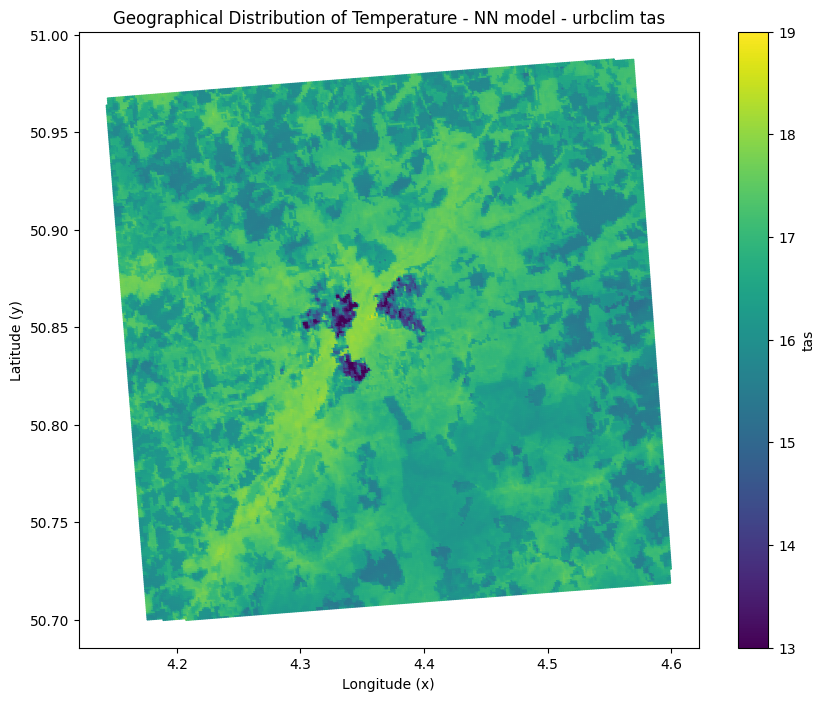

In [53]:
# plot NN model predicted tas
urbclim_pred_nn = pd.DataFrame()

urbclim_pred_nn['tas'] = y_pred_nn['residue'] + test_set['t2m_corrected']
urbclim_pred_nn[['y','x','time']] = test_set[['y','x','time']]

print(urbclim_pred_nn)

first_stamp_data_nn = urbclim_pred_nn[(urbclim_pred_nn['time']=="2017-07-01 00:00:00")]
print(first_stamp_data_nn)
tas_min_nn = first_stamp_data_nn['tas'].min()
tas_max_nn = first_stamp_data_nn['tas'].max()
print("tas min: " ,tas_min_nn)
print("tas max: " ,tas_max_nn)
plot_y(first_stamp_data_nn, 'NN model - urbclim tas', 'tas')

### MLP model

In [54]:
#use ANN model to predict the temp
from sklearn.neural_network import MLPRegressor


ann_model = MLPRegressor(hidden_layer_sizes=(50, 10),
                                activation='relu',
                                solver='adam',
                                max_iter=100,
                                random_state=45,
                                early_stopping=True,
                                validation_fraction=0.1,
                                n_iter_no_change=20,
                                verbose=True,
                                alpha=0.03)


/Users/wangy/Documents/MACS/Thesis/thesis_code/thesis_featurevisual/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Iteration 1, loss = 0.18173021
Validation score: 0.747878
Iteration 2, loss = 0.14302977
Validation score: 0.771041
Iteration 3, loss = 0.13245669
Validation score: 0.788035
Iteration 4, loss = 0.12656402
Validation score: 0.800031
Iteration 5, loss = 0.12235632
Validation score: 0.798974
Iteration 6, loss = 0.11998463
Validation score: 0.801902
Iteration 7, loss = 0.11863097
Validation score: 0.806971
Iteration 8, loss = 0.11776478
Validation score: 0.810930
Iteration 9, loss = 0.11704248
Validation score: 0.811419
Iteration 10, loss = 0.11635303
Validation score: 0.815852
Iteration 11, loss = 0.11570864
Validation score: 0.819409
Iteration 12, loss = 0.11512179
Validation score: 0.820108
Iteration 13, loss = 0.11483758
Validation score: 0.815816
Iteration 14, loss = 0.11440346
Validation score: 0.818359
Iteration 15, loss = 0.11402311
Validation score: 0.812534
Iteration 16, loss = 0.11369406
Validation score: 0.824443
Iteration 17, loss = 0.11343481
Validation score: 0.821922
Iterat

/Users/wangy/Documents/MACS/Thesis/thesis_code/thesis_featurevisual/venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


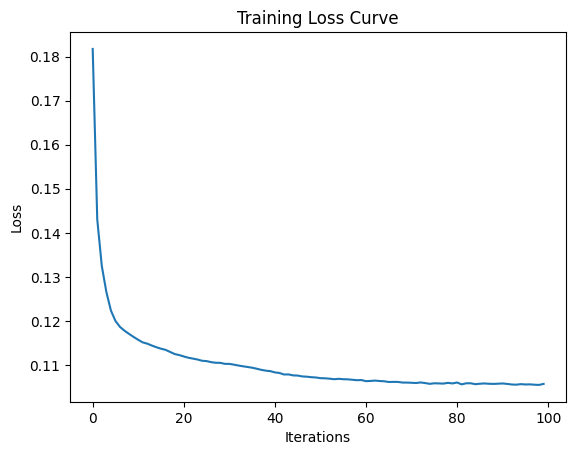

          residue
0        1.285553
1        1.299755
2        1.159447
3        1.171714
4        0.981188
...           ...
6519379  0.350648
6519380 -0.506350
6519381  0.625582
6519382  0.573340
6519383 -0.339587

[6519384 rows x 1 columns]


In [55]:
# y_train = y_train.ravel()
ann_model.fit(X_train_normalized, y_train)

# Plot training loss
plt.plot(ann_model.loss_curve_)
plt.title("Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

y_pred_mlp = ann_model.predict(X_test_normalized)
y_pred_mlp = pd.DataFrame(y_pred_mlp, columns=['residue'])
print(y_pred_mlp)

In [56]:
y_pred_mlp[['y','x','time']] = test_set[['y','x','time']]

y_pred_mlp_day = y_pred_mlp[(y_pred_mlp['time'].dt.hour >= 6) & (y_pred_mlp['time'].dt.hour < 18)]
y_pred_mlp_night = y_pred_mlp[(y_pred_mlp['time'].dt.hour < 6) | (y_pred_mlp['time'].dt.hour >= 18)]

print(y_pred_mlp_day)
print(y_pred_mlp_night)

          residue          y         x                time
543282   1.774872  50.700043  4.207803 2017-07-01 06:00:00
543283   1.785419  50.700110  4.209215 2017-07-01 06:00:00
543284   1.716782  50.700184  4.210626 2017-07-01 06:00:00
543285   1.699061  50.700256  4.212038 2017-07-01 06:00:00
543286   1.709437  50.700325  4.213450 2017-07-01 06:00:00
...           ...        ...       ...                 ...
5976097 -0.034551  50.986958  4.547782 2017-07-03 17:00:00
5976098 -0.426437  50.987026  4.549203 2017-07-03 17:00:00
5976099 -0.335850  50.987090  4.550624 2017-07-03 17:00:00
5976100 -0.421578  50.987160  4.552045 2017-07-03 17:00:00
5976101 -0.428552  50.987225  4.553465 2017-07-03 17:00:00

[3259692 rows x 4 columns]
          residue          y         x                time
0        1.285553  50.700043  4.207803 2017-07-01 00:00:00
1        1.299755  50.700110  4.209215 2017-07-01 00:00:00
2        1.159447  50.700184  4.210626 2017-07-01 00:00:00
3        1.171714  50.700256

In [57]:
model_name = "MLP"
maes_general[model_name], mses_general[model_name], rmses_general[model_name] = calculate_errors(y_test['residue'], y_pred_mlp['residue'])
print("Errors during day:")
maes_day[model_name], mses_day[model_name], rmses_day[model_name] = calculate_errors(y_test_day['residue'], y_pred_mlp_day['residue'])
print("Errors during night:")
maes_night[model_name], mses_night[model_name], rmses_night[model_name] = calculate_errors(y_test_night['residue'], y_pred_mlp_night['residue'])

Mean Absolute Error (MAE): 1.121232155574952
Mean Squared Error (MSE): 1.953861814405511
Root Mean Squared Error (RMSE): 1.3978060718159409
Errors during day:
Mean Absolute Error (MAE): 1.1985816575871222
Mean Squared Error (MSE): 2.3182959681238837
Root Mean Squared Error (RMSE): 1.522595142552308
Errors during night:
Mean Absolute Error (MAE): 1.0438826535627825
Mean Squared Error (MSE): 1.5894276606871354
Root Mean Squared Error (RMSE): 1.260725053565263


               tas          y         x                time
0        16.716506  50.700043  4.207803 2017-07-01 00:00:00
1        16.731524  50.700110  4.209215 2017-07-01 00:00:00
2        16.605493  50.700184  4.210626 2017-07-01 00:00:00
3        16.624892  50.700256  4.212038 2017-07-01 00:00:00
4        16.407557  50.700325  4.213450 2017-07-01 00:00:00
...            ...        ...       ...                 ...
6519379  15.755281  50.986958  4.547782 2017-07-03 23:00:00
6519380  14.917171  50.987026  4.549203 2017-07-03 23:00:00
6519381  16.050526  50.987090  4.550624 2017-07-03 23:00:00
6519382  15.989684  50.987160  4.552045 2017-07-03 23:00:00
6519383  15.080460  50.987225  4.553465 2017-07-03 23:00:00

[6519384 rows x 4 columns]
tas min:  14.64145496854268
tas max:  18.21878393127899


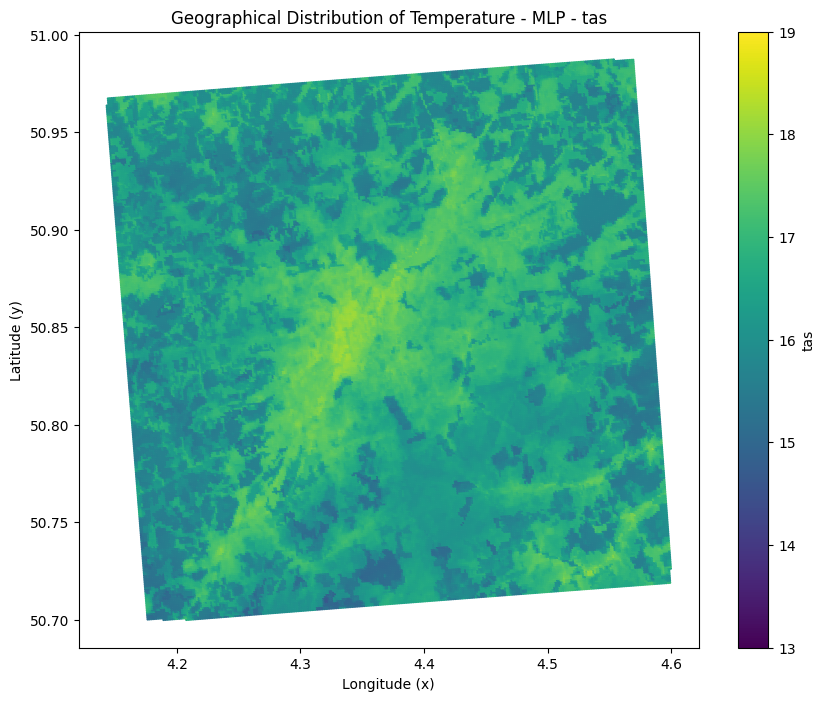

In [58]:
# sum up y_pred and corrected ERA5 to get the urbclim prediction
urbclim_pred_mlp = pd.DataFrame()

urbclim_pred_mlp['tas'] = y_pred_mlp['residue'] + test_set['t2m_corrected']
urbclim_pred_mlp[['y','x','time']] = test_set[['y','x','time']]

print(urbclim_pred_mlp)

# extract the first timestamp y_pred and plot it
# first_stamp_data = urbclim_pred[(urbclim_pred['time']=="2016-07-01 12:00:00") | (urbclim_pred['time']=="2016-07-01")]
first_stamp_data_mlp = urbclim_pred_mlp[(urbclim_pred_mlp['time']=="2017-07-01 00:00:00")]
tas_min_mlp = first_stamp_data_mlp['tas'].min()
tas_max_mlp = first_stamp_data_mlp['tas'].max()
print("tas min: " ,tas_min_mlp)
print("tas max: " ,tas_max_mlp)
plot_y(first_stamp_data_mlp, 'MLP - tas', 'tas')

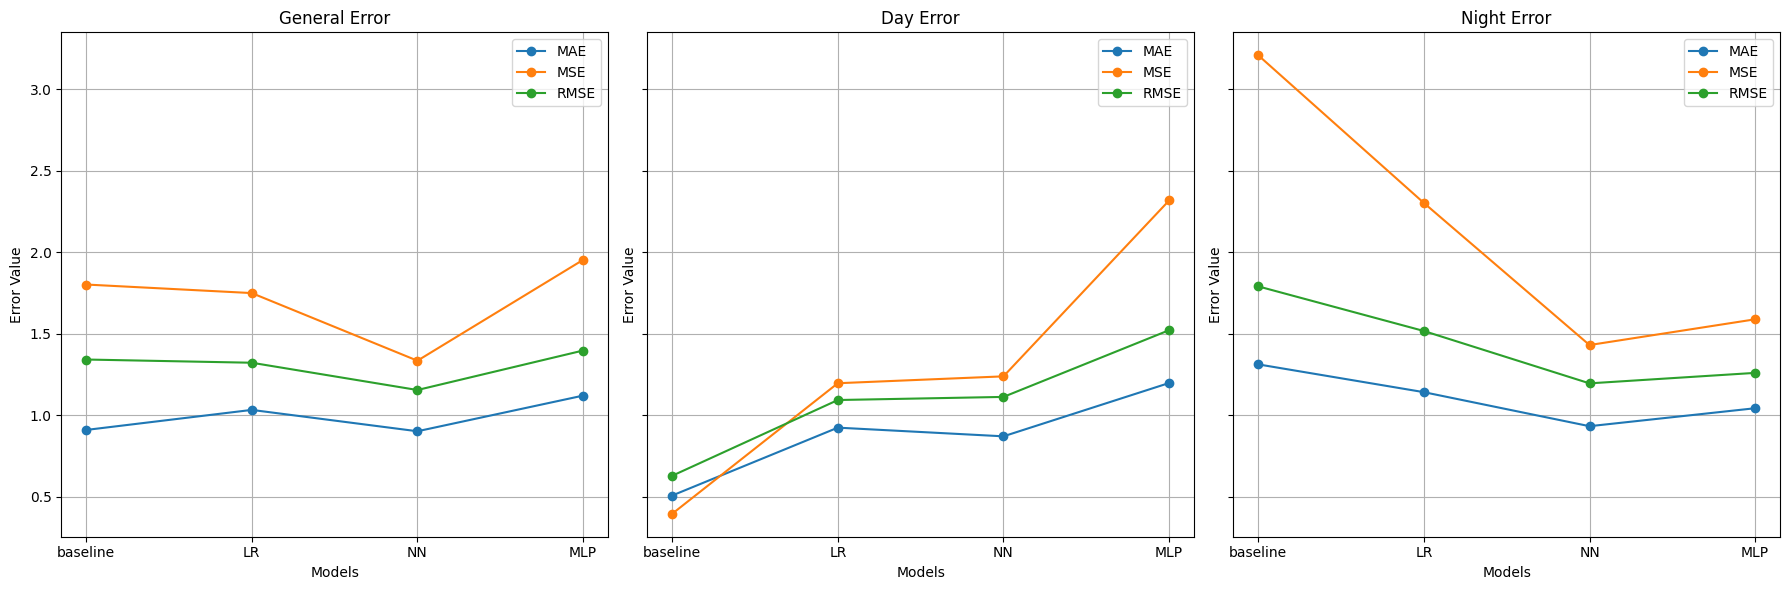

In [59]:
# Define error type labels
error_labels = ['MAE', 'MSE', 'RMSE']

# Draw subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Traverse the errors dictionary and draw the data of general, day and night respectively
for ax, (error_name, error_dicts) in zip(axes, errors.items()):
    for idx, error_dict in enumerate(error_dicts):
        models = list(error_dict.keys()) # x axis: model name
        values = list(error_dict.values()) # y axis: error value
        ax.plot(models, values, marker='o', linestyle='-', label=error_labels[idx])

    ax.set_title(f"{error_name.replace('_', ' ').title()}") # Set title
    ax.set_xlabel("Models")
    ax.set_ylabel("Error Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()